## **Dipole-Model Reflectarray - Tutorial Notebook**

Illustrates the design (inverse model) and analysis/prediction (forward model) of a grayscale reflectarray using a point dipole model.  
The reflectarray dipole model is described in https://ieeexplore.ieee.org/abstract/document/10045765 (and its cited references).

### Import libraries

Dipole-model reflectarray Python code can be downloaded from https://github.com/aaronvd/dipole-model-reflectarray

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.constants
import sys
sys.path.append('..')               # if necessary, replace this with the path to the reflectarray github repository folder
from reflectarray import element
from reflectarray.reflectarray import Reflectarray
from reflectarray.feed import Feed
from reflectarray.feed import PyramidalHorn
from reflectarray.system import System

%matplotlib inline          # 'inline' displays plots in the notebook. Can alternatively specify 'qt' to plot in external windows.

UsageError: unrecognized arguments: # 'inline' displays plots in the notebook. Can alternatively specify 'qt' to plot in external windows.


### Define operating frequency and reflectarray unit element (patch)

This cell defines a patch element, which can be modelled as two magnetic dipoles over a ground plane.  

<center><img src="figures/patch-dipoles.png">

Here, each dipole is defined analytically according to a Lorentzian resonator description:  

$$ \alpha=\frac{F\omega^2}{\omega_0^2-\omega^2+j\gamma\omega} $$  

$\omega_0$ is the resonance frequency, and $\omega$ is the operating frequency. $F$ is the coupling strength, and $\gamma=\omega_0 / 2Q$ is the damping factor.

The lattice vector direction specifies the polarization of the magnetic dipoles, determined by the geometry of the patch.  

We specify a range of tuning states (corresponding to, e.g., different patch geometries or varactor capacitance values) at the operating frequency. This gives us a "dictionary" of available element values (phase and magnitude) that we'll use later to design the reflectarray.

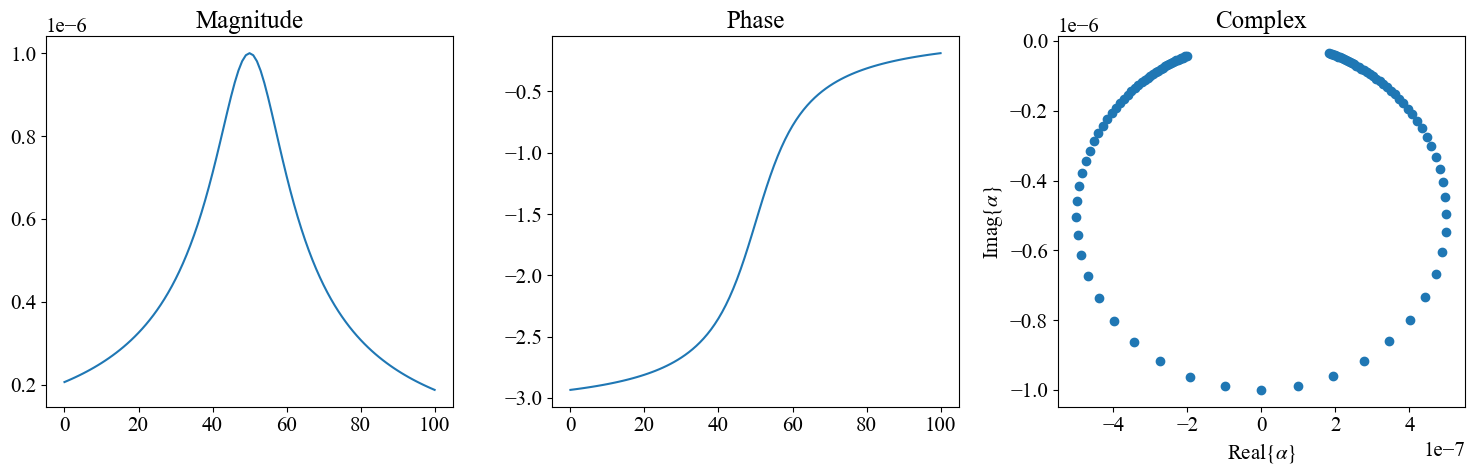

In [2]:
C = scipy.constants.c
f = 10E9
lam = C / f

patch1 = element.Patch(f=f, 
                       Q=25,                                    # Quality (Q) factor. Higher number means sharper resonance
                       lattice_vectors=np.array([[0, 1, 0]]), 
                       normalize=True)
patch1.alpha = patch1.alpha * 1E-6
patch1.plot()

### Define reflectarray geometry

In the following, we define the reflectarray geometry. A spacing equal to $\lambda / 2$ ensures we can steer the beam over $\pm 90^\circ$ without incurring grating lobes.

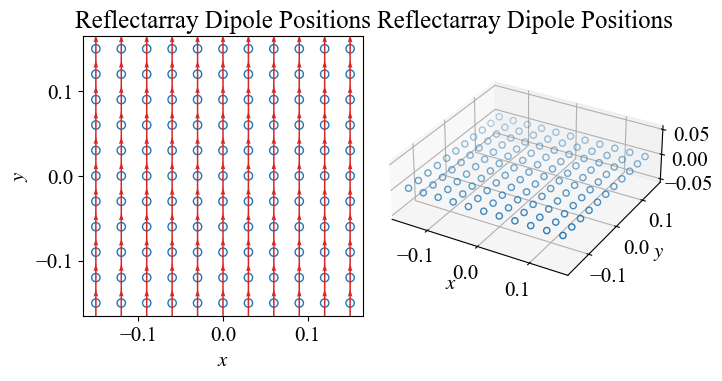

In [3]:
L = 10 * lam
delta_x = lam/1
delta_y = lam/1
x = np.arange(-L/2, L/2+delta_x, delta_x)
y = np.arange(-L/2, L/2+delta_y, delta_y)

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

array = Reflectarray(patch1, 
                     x=x, 
                     y=y)
array.plot(ax=ax1, show_lattice_vectors=True)

# array.deform(axis='x', R_cylinder=10*lam)         # this will optionally deform the array over a cylindrical surface
array.plot(ax=ax2, show_normals=False, show_lattice_vectors=False)

### Define source

The following cell defines the source which excites the reflectarray. We'll use a pyramidal horn antenna rotated $45^{\circ}$ from the normal and oriented so that the $H$ field is parallel to the $y$ axis (i.e. the defined polarization of the patch elements). We can specify the source gain to later estimate the overall reflectarray system efficiency. Gain ($G$) is related to efficiency by

$$ G = eD $$  

where  

$$ e = \mathrm{Radiation}\: \mathrm{Efficiency} = \frac{P_{out}}{P_{in}} $$  
$$ D(\theta,\phi) = \mathrm{Directivity} = \frac{4\pi U(\theta, \phi)}{P_{rad}} $$  
$$ U(\theta, \phi) = \mathrm{Radiation}\:\mathrm{Intensity}\approx \frac{r^2}{2\eta} \left[|E_{\theta}|^2 + |E_{\phi}|^2\right]

Gain: 10.00 dB


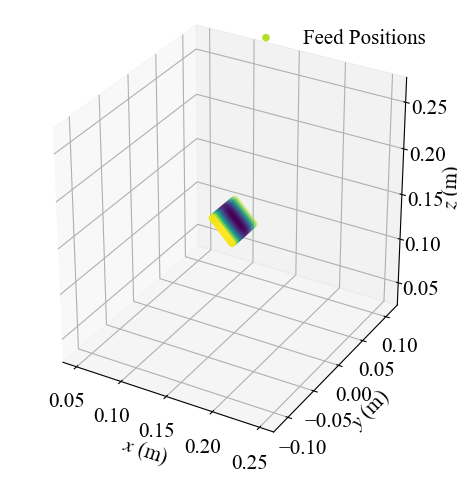

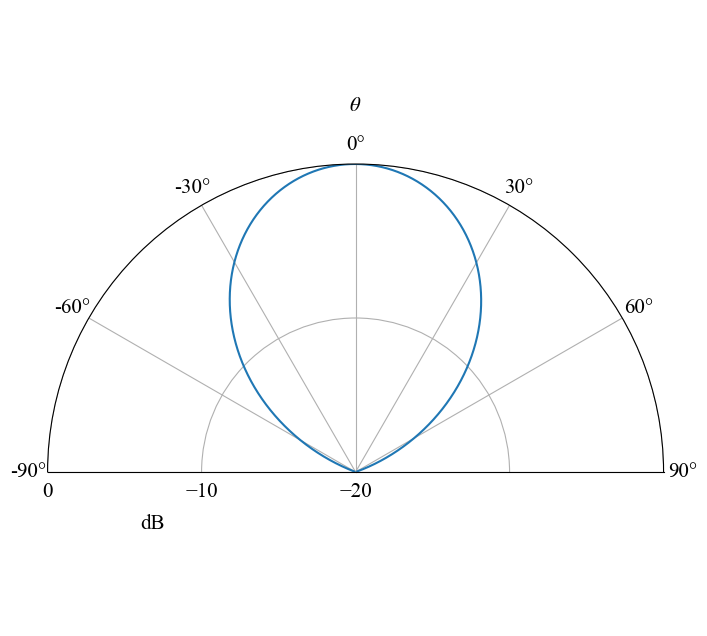

In [4]:
horn = PyramidalHorn(f=f, 
                     E0=1, 
                     rotation=(45, 0, 90), 
                     r_offset=(5*lam, 0, 5*lam), 
                     gain=10)
_ = horn.compute.calculate_gain()
horn.plot(quiver=False, plot_type='3D', plot_value='J_m')
horn.plot_fields(plot_type='1D', dB_min=-20)

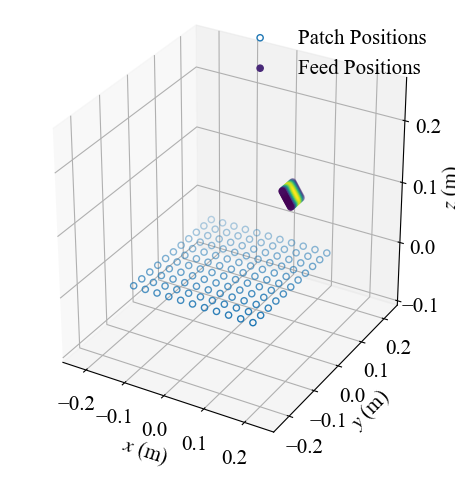

In [5]:
system1 = System(array, horn)
system1.plot()

### Design reflectarray

Now that the reflectarray geometry has been defined, we need to specify a desired beam direction and design the reflectarray (distribution of tuning states) over the antenna surface accordingly. 

To achieve a beam in a given direction in the far field, we need to create a set of currents across the aperture which, when radiating to the far field, "focuses" to a beam in the desired direction. In the conventional reflectarray design procedure, this means we want to place an element at each location which provides a phase shift. When added to the phase of source field, the distribution of element phases + source phases over the aperture should result in a plane wave projected onto the surface (recall that the Fourier transform of a plane wave is a delta function; far field propagation can mathematically be described by a Fourier transform). This yields the traditional reflectarray design equation:  

$$ \psi_i = -\psi_{S,i} - \mathbf{k}_b\cdot \mathbf{r}_i + 2\pi N $$  

where  

$ \psi_i = $ desired phase at element position $i$  
$ \psi_{S,i} $ = source field phase at element position $i$  
$ \mathbf{k}_b $ = desired beam wave vector = $\left[ k\mathrm{sin}\theta_0 \mathrm{cos}\phi_0, k\mathrm{sin}\theta_0 \mathrm{sin}\phi_0, k\mathrm{cos}\theta_0 \right] $  
$ \mathbf{r}_i $ = position vector of element $i$  
$ N $ = an integer

Computing feed fields...
Computing ideal polarizabilities...
Computing constrained polarizabilities...


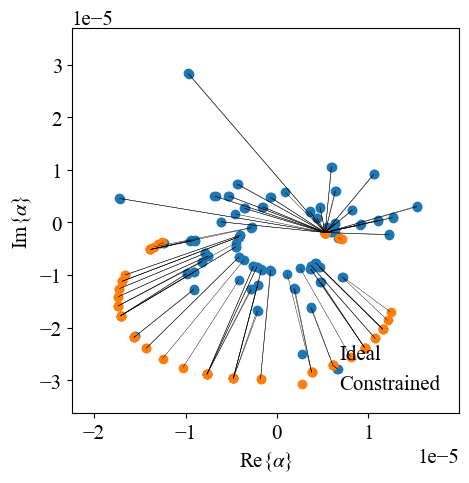

In [11]:
system1.design(theta_beam=25, 
               phi_beam=0, 
               mapping='phase', 
               R_far=10, 
               scale=1)
system1.plot_mapping(lattice_index=0, scale=1.3)

In [12]:
system1.propagate(delta_theta=1, delta_phi=2)

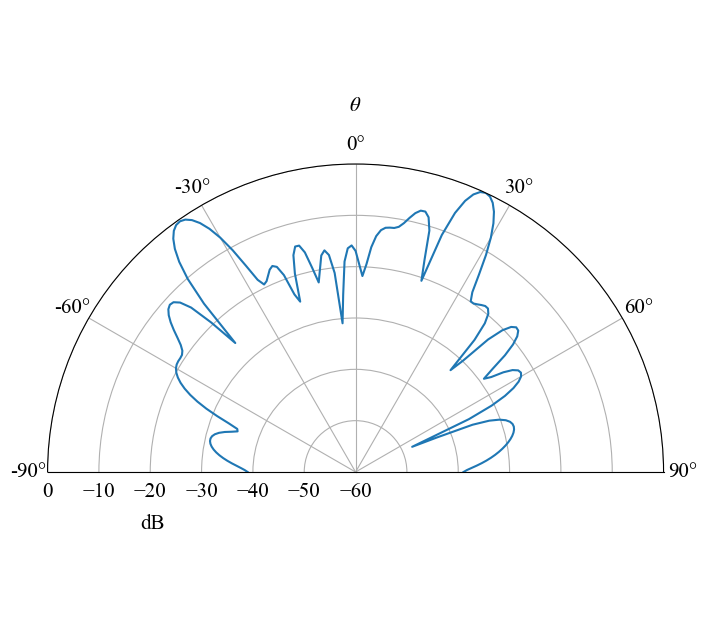

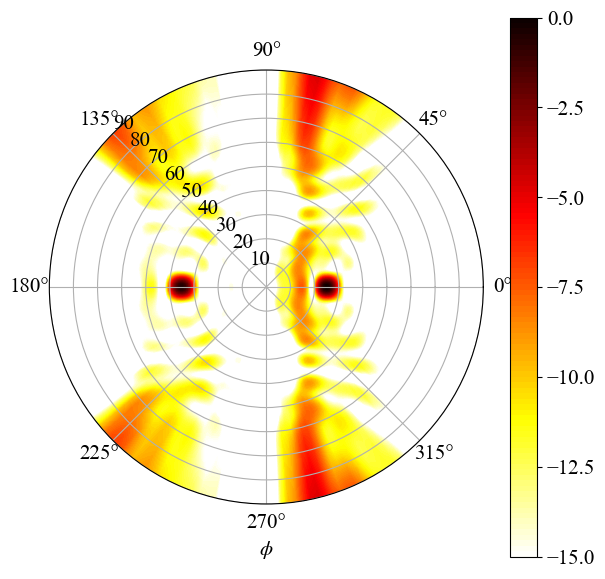

In [13]:
system1.plot_fields(plot_type='1D', phi_slice=0, dB_min=-60)
system1.plot_fields(plot_type='2D', dB_min=-15)

In [14]:
system1.calculate_beam_metrics()

Beamwidth: 6.21 degrees
Directivity: 16.73 dB
Gain: 19.35 dB
Efficiency: 182.84%
